### Setup

In [1]:
%load_ext autoreload
%autoreload --print 3

In [20]:
import jax.random as jr
jr.KeyArray = jr.PRNGKey
import shape_norm

from shape_norm.io import loaders
from shape_norm.models import joint
from shape_norm import config
from shape_norm.models import instantiation, setup, pose, morph, util as model_util
from shape_norm import fitting
from shape_norm.fitting import em
from shape_norm.io import alignment, features
from shape_norm.io.armature import Armature
from shape_norm.fitting import methods
from shape_norm.fitting import scans
from shape_norm.pca import fit_with_center, CenteredPCA, PCAData
from shape_norm.io.dataset import PytreeDataset
from shape_norm.io.dataset_refactor import Dataset, SessionMetadata
from shape_norm.models.morph.lowrank_affine import LRAParams, model as lra_model
from shape_norm.viz import styles

from blscale_loader import loader, linear_skeletal as blscale_ls

from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from shape_norm.viz import util as vu
from scipy import spatial
import itertools as iit
import numpy as np
import re
import jax
import jax.numpy as jnp
from pprint import pprint
from ruamel.yaml import YAML
import scipy.stats
from pathlib import Path
import matplotlib as mpl
import joblib as jl
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import tqdm
import itertools as iit
import pandas as pd
import seaborn as sns


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plot_dir = '/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.2_classif'
params_file = "/Users/kaifox/projects/mph/generative_api/test/notebooks/panels/plot_params.yml"

plot_meta = YAML(typ='safe').load(open(params_file, 'r'))
colors, plotter = styles.init_plt(plot_dir, style='default', fmt = 'pdf', **plot_meta['savefig'])
plt.rcParams.update(plot_meta['rc'])
plot_root = Path(plotter.plot_dir)

### supporting funcs


#### General supporting funcs

In [4]:
import jax.random as jr

jr.KeyArray = jr.PRNGKey
import numpy as np
import numpy.linalg as la
from scipy.signal import savgol_filter
import matplotlib.colors as mpl_col

# calculus and statistics
val_and_deriv = lambda x, w=5: (x, savgol_filter(x, w, polyorder=1, deriv=1, axis=0))
vel_acc = lambda x, w=5: val_and_deriv(  # x, shape (t, ..., spatial)
    la.norm(savgol_filter(x, w, polyorder=1, deriv=1, axis=0), axis=-1), w=w
)
cos = lambda a, b: np.clip(
    (a * b).sum(axis=-1) / (la.norm(a, axis=-1) * la.norm(b, axis=-1)), -1, 1
)
cov = lambda x, y: (x * y).mean(axis=-1) - x.mean(axis=-1) * y.mean(axis=-1)
corr = lambda a, b: cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))
coef = lambda a, b: cov(a, b) / cov(a, a)
windowed_cov = lambda x, y, w: cov(
    *np.lib.stride_tricks.sliding_window_view(
        np.pad(
            np.stack([x, y]),
            ((0, 0), (int(np.ceil((w - 1) / 2)), int(np.floor((w - 1) / 2)))),
        ),
        window_shape=w,
        axis=1,
    )
)

# skeleton functions
bone_locations = lambda keypts, armature: np.stack(
    [
        keypts[..., armature.bones[i, 1], :] - keypts[..., armature.bones[i, 0], :]
        for i in range(len(armature.bones))
    ],
    axis=-2,
)
bone_lengths = lambda keypts, armature: la.norm(
    bone_locations(keypts, armature), axis=-1
)
elevation = (
    lambda arr: (
        np.arccos(cos(arr, arr * np.array([1, 1, 0])[None])) * np.sign(arr[:, 2])
    )
    * 180
    / np.pi
)
rotation = (
    lambda arr: (
        np.arccos(cos(arr, arr * np.array([1, 0, 1])[None])) * np.sign(arr[:, 1])
    )
    * 180
    / np.pi
)
short_bone_names = lambda armature: [
    armature.keypoint_names[int(i)] for i, j in armature.bones
]
long_bone_names = lambda armature: [
    f"{armature.keypoint_names[int(i)]}-{armature.keypoint_names[int(j)]}"
    for i, j in armature.bones
]


# model manipulation
def lra_anchor_poses(params, magnitudes=90):
    L = params.n_dims

    if isinstance(magnitudes, (int, float)):
        magnitudes = magnitudes * np.ones(L)

    # (n_bodies, n_dims, 1)
    anchors = (params.offset + params.offset_updates).reshape(params.n_bodies, -1, 1)
    # (n_bodies, n_dims, n_modes + 1)
    anchors = np.concatenate(
        [
            anchors,
            anchors + magnitudes[None, None] * (params.modes + params.mode_updates),
        ],
        axis=-1,
    )

    return anchors


def lra_induced_anchors(dataset, config, params, magnitudes, n_neighbors):
    from kpsn.models import util
    from kpsn.models.morph.lowrank_affine import model

    anchors = lra_anchor_poses(params, magnitudes)
    ref_data = dataset.get_session(dataset.ref_session)
    ref_anchor_diff = (
        ref_data[..., None]
        - anchors[None, dataset.session_body_id(dataset.ref_session)]
    )
    near_anchors_ix = np.array(
        [
            la.norm(ref_anchor_diff[..., j], axis=(-1)).argsort(axis=0)[:n_neighbors]
            for j in range(anchors.shape[-1])
        ]
    )
    induced_anchors = util.induced_reference_keypoints(
        dataset,
        config,
        model,
        params,
        include_reference=True,
        ref_frames=ref_data[near_anchors_ix].mean(axis=1),
    )

    return induced_anchors



### plotting


def plot_mouse_3d(
    frame,
    ax,
    armature,
    elev,
    rot,
    colors=None,
    bone_n=40,
    point_size=10,
    line_size=2,
    line_colors=None,
    point_kws={},
    line_kws={},
    boundary=True,
    set_aspect=True,
    label = None
):
    """all keys in point kws should be present in line kws"""

    if colors is None:
        import seaborn as sns

        colors = mpl_col.to_rgba(sns.color_palette("Blues", 10 + frame.shape[0])[10:])
    if line_colors is None:
        line_colors = colors
    colors = np.array([mpl_col.to_rgba(x) for x in colors])
    line_colors = np.array([mpl_col.to_rgba(x) for x in line_colors])
    point_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **point_kws,
    }
    line_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **line_kws,
    }

    # --- points

    x, y, z, c, s = [], [], [], [], []
    x.append(frame[:, 0])
    y.append(frame[:, 1])
    z.append(frame[:, 2])
    c.append(colors)
    s.append([point_size] * armature.n_kpts)
    kws = {k: [] for k in point_kws}
    concat_keys = []
    for k, v in point_kws.items():
        if np.array(v).shape[:1] == (armature.n_kpts,):
            concat_keys.append(k)
            kws[k].append(v)
        else:
            kws[k] = v

    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])
    point_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    # --- "lines"

    x, y, z, c, s = [], [], [], [], []
    kws = {k: [] for k in line_kws}
    concat_keys = []
    for i, (ch, pa) in enumerate(armature.bones):
        x.append(np.linspace(frame[ch, 0], frame[pa, 0], bone_n)[1:-1])
        y.append(np.linspace(frame[ch, 1], frame[pa, 1], bone_n)[1:-1])
        z.append(np.linspace(frame[ch, 2], frame[pa, 2], bone_n)[1:-1])
        c.append(np.full([bone_n - 2, 4], line_colors[ch]))
        s.append(np.full([bone_n - 2], line_size))
        for k, v in line_kws.items():
            if np.array(v).shape[:1] == (armature.n_kpts,):
                concat_keys.append(k)
                kws[k].append(np.full((bone_n - 2,) + np.array(v).shape[1:], v[ch]))
            else:
                kws[k] = v
    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])

    line_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    ax.view_init(elev, rot)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])
    if not boundary:
        ax.xaxis.pane.set_linewidth(0)
        ax.yaxis.pane.set_linewidth(0)
        ax.zaxis.pane.set_linewidth(0)
        ax.xaxis.line.set_linewidth(0)
        ax.yaxis.line.set_linewidth(0)
        ax.zaxis.line.set_linewidth(0)

    
    # use a.set_box_aspect to make the aspect equal to the ratio of the limits
    if set_aspect:
        xrng = np.ptp(ax.get_xlim())
        yrng = np.ptp(ax.get_ylim())
        zrng = np.ptp(ax.get_zlim())
        ax.set_box_aspect([xrng, yrng, zrng])

    return point_artist, line_artist

#### Raw keypoint data supporting funcs

In [5]:
def raw_data_armature_meta():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base', 't_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 't_base', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

def raw_data_armature_meta_no_tail():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

keypt_names = [
    'shldr',
    'back',
    'hips',
    't_base',
    'head',
    'l_ear',
    'r_ear',
    'nose',
    'lr_knee',
    'lr_foot',
    'rr_knee',
    'rr_foot',
    'lf_foot',
    'rf_foot'
]
keypt_ix = lambda k: keypt_names.index(k)
_names, _parents, _bones, _root = raw_data_armature_meta_no_tail()
arms = Armature(_names, _bones, _root, anterior=[], posterior=[])

# bone_names = [f'{keypt_names[i]}-{keypt_names[j]}' for i, j in armature.bones]
bone_names = [
    'hi back', #  'back-shldr',
    'lo back', #  'hips-back',
    'rump', #  't_base-hips',
    'neck', #  'head-shldr',
    'left ear', #  'l_ear-head',
    'right ear', #  'r_ear-head',
    'head', #  'nose-head',
    'left hindlimb', #  'lr_knee-hips',
    'left hind foot', #  'lr_foot-lr_knee',
    'right hindlimb', #  'rr_knee-hips',
    'right hind foot', #  'rr_foot-rr_knee',
    'left forelimb', #  'lf_foot-shldr',
    'right forelimb' #  'rf_foot-shldr'
]
keypt_parent = lambda ix, armature = arms: armature.bones[armature.bones[:, 0] == ix, 1][0]
has_parent = lambda ix, armature = arms: np.any(armature.bones[:, 0] == ix)
bone_ix = lambda keypt_ix, armature = arms: np.where(armature.bones[:, 0] == keypt_ix)[0][0]

joints = np.array([(child, parent, keypt_parent(parent)) for child, parent in arms.bones if has_parent(parent)])
joint_names = [f'{keypt_names[c]}-{keypt_names[p]}-{keypt_names[g]}' for c, p, g in joints]
joint_names = [
'back', #  'hips-back-shldr',
'hips', #  't_base-hips-back',
'left ear', #  'l_ear-head-shldr',
'right ear', #  'r_ear-head-shldr',
'head', #  'nose-head-shldr',
'left hindlimb', #  'lr_knee-hips-back',
'left hind foot', #  'lr_foot-lr_knee-hips',
'right hindlimb', #  'rr_knee-hips-back',
'right hind foot', #  'rr_foot-rr_knee-hips'
]

short_names = [keypt_names[i] for i, j in arms.bones]
full_joint_angles_func = (
    lambda kpts, joint_ix, joints: 180
    / np.pi
    * np.arccos(
        np.clip(
            cos(
                kpts[:, joints[joint_ix, 0], :] - kpts[:, joints[joint_ix, 1], :],
                kpts[:, joints[joint_ix, 2], :] - kpts[:, joints[joint_ix, 1], :],
            ),
            -1,
            1,
        )
    )
)
joint_angles = lambda kpts, joint_ix: full_joint_angles_func(kpts, joint_ix, joints)

#### Supervised ethogram supporting funcs

In [6]:
bhv_keys = {
    'rear': 'absolute_reer',
    'loco': 'locomotion',
    'raise': 'head_raise',
    'turn': 'bend',
    'hunch': 'hunch'
}
bhv_names = {
    'rear': "Rear",
    'loco': "Walk",
    'raise': "Head\nRaise",
    'turn': "Turn",
    'hunch': "Hunch",
}

#### Dataset functions

In [7]:
_with_match = lambda test, pattern, f: f(m) if (m := re.search(pattern, test)) else None
_name_func = lambda path, *a: _with_match(
    path, r"(?:/.*)+/\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy",
    lambda m: f"{m.group(1)}")

def full_ontogeny_data(data_dir, session_filter=None, ref_session=None):
    _sources = dict(map(lambda x: (_name_func(str(x)),) * 2, data_dir.glob(f"*.npy")))
    if session_filter is not None:
        _sources = {k: v for k, v in _sources.items() if session_filter(k)}
    ont_keypoints, _ = loader.from_sources_dict(
        data_dir,
        _sources,
        extension='.npy',
        name_func=_name_func,
    )
    names, parents, _, _ = raw_data_armature_meta()

    if ref_session is None:
        ref_session = list(ont_keypoints.keys())[0]

    project_config_kws = {
        "session_names": ont_keypoints.keys(),
        "bodies": {s: f'b-{s}' for s in ont_keypoints},
        "ref_session": ref_session,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, ont_keypoints

def full_ontogeny_data_aligned(data_dir, session_filter=None, use_keypoints=None, scale_ntt=False):
    project_config_kws, ont_keypoints = full_ontogeny_data(data_dir, session_filter)
    if use_keypoints is None:
        use_keypoints = project_config_kws['keypoint_names']
    dataset = loaders.arrays.from_arrays(ont_keypoints, dict(
        type='arrays',
        subsample=None,
        subsample_to=None,
        ref_session=project_config_kws['ref_session'],
        sessions={s: dict(body=b) for s, b in project_config_kws['bodies'].items()},
        keypoint_names=project_config_kws['keypoint_names'],
        use_keypoints=use_keypoints,
        anterior=None,
        posterior=None,
        invert_axes=None,
    ))
    aligned, align_inv = alignment.align(dataset, dict(
        type='sagittal',
        origin='hips',
        anterior='head',
        rescale=scale_ntt,
        rescale_mode='session',
    ))
    return aligned, dataset, align_inv
    

#### Plotting funcs

In [216]:
def getc(spec):
    try:
        from cmap import Colormap, Color
        try:
            return Color(spec)
        except ValueError as e:
            stop = spec.split(':')[-1]
            if stop.startswith('.'):
                stop = float(stop)
            else:
                stop = int(stop)
            cm = Colormap(':'.join(spec.split(':')[:-1]))
            return cm(stop)
    except ImportError:
        return spec
    
plot_meta = YAML(typ='safe').load(open(params_file, 'r'))
age_pal = {k: getc(c) for k, c in plot_meta['colors']['age'].items()}
bhv_pal = {k: getc(c) for k, c in plot_meta['colors']['bhv'].items()}

plotdrop_kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts) if np.array(c).ndim < 2 else c,
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(x[..., 2].min() + z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(x[..., 1].max() + y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(x[..., 0].min() + xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, lsm=1, shad=True, dropax=None, shad_x = True, shad_y=True, shad_z=True, **kws: [
    plot_mouse_3d(f, a, **{**plotdrop_kws(c, sm * 15, 1.5 * lsm), **kws})
    ] + [
    dropax := dropax if dropax is not None else a,
    ] + ([
    plot_mouse_3d(dropz(f, -7), dropax, **plotdrop_kws('.9', sm * 7, 1 * lsm)) if shad_z else None,
    plot_mouse_3d(dropy(f, 10), dropax, **plotdrop_kws('.9', sm * 7, 1 * lsm)) if shad_y else None,
    plot_mouse_3d(dropx(f, -7), dropax, **plotdrop_kws('.9', sm * 7, 1 * lsm)) if shad_x else None,
] if shad else [])


classif_strip = lambda ax, keys, data, colors, offset, point_ms=1, **kws: vu.grouped_stripplot(
    vu.expand_groups([np.array(data[a]) for a in keys], keys),
    x=np.arange(len(keys)) + offset,
    ax=ax,
    colors=dict(zip(keys, colors)),
    points_kw=dict(ms=point_ms),
    errorbar_kw=dict(ms=2, elinewidth=0),
    # error = lambda a, **kw: vu.ci(a, level=0.95, n=1000),
    # error = lambda a, **kw: np.nanstd(a),
    **{
        **dict(
            xticks="",
            lighten_points=0.5,
            offset=False,
        ),
        **kws,
    },
)

#### Classifier funcs

In [69]:
def indiv_holdout(feats, groups, seed, shuffle):
    rng = np.random.default_rng(seed)
    feat_val = []
    feat_trn = []
    tgt_val = []
    tgt_trn = []
    tgt_keys = dict(zip(groups.keys(), range(len(groups))))
    for grp_key, grp in groups.items():
        holdout = rng.integers(len(grp))
        feat_val.append(feats[grp[holdout]])
        feat_trn.extend([feats[s] for i, s in enumerate(grp) if i != holdout])
        lens = [len(feats[s]) for s in grp]
        tgt_val.append(np.full(lens[holdout], tgt_keys[grp_key]))
        tgt_trn.extend([np.full(l, tgt_keys[grp_key]) for i, l in enumerate(lens) if i != holdout])
    feat_val = np.concatenate(feat_val, axis = 0)
    feat_trn = np.concatenate(feat_trn, axis = 0)
    tgt_val = np.concatenate(tgt_val, axis = 0)
    tgt_trn = np.concatenate(tgt_trn, axis = 0)
    if shuffle:
        tgt_trn = rng.permutation(tgt_trn)
    return feat_trn, feat_val, tgt_trn, tgt_val

def frame_holdout(feats, groups, seed, shuffle, train_pct = 0.8):
    rng = np.random.default_rng(seed)
    feat_val = []
    feat_trn = []
    tgt_val = []
    tgt_trn = []
    tgt_keys = dict(zip(groups.keys(), range(len(groups))))
    for grp_key, grp in groups.items():
        for s in grp:
            x = feats[s]
            trn, val = np.split(rng.permutation(len(x)), [int(train_pct * len(x))])
            feat_trn.append(x[trn])
            feat_val.append(x[val])
            tgt_trn.append(np.full(len(trn), tgt_keys[grp_key]))
            tgt_val.append(np.full(len(val), tgt_keys[grp_key]))
    feat_val = np.concatenate(feat_val, axis = 0)
    feat_trn = np.concatenate(feat_trn, axis = 0)
    tgt_val = np.concatenate(tgt_val, axis = 0)
    tgt_trn = np.concatenate(tgt_trn, axis = 0)
    if shuffle:
        tgt_trn = rng.permutation(tgt_trn)
    return feat_trn, feat_val, tgt_trn, tgt_val

def pairwise_group_acc(feats, groups, ref, nonref, n_iter = 40):
    scores = {a: [] for a in nonref}
    scores_null = {a: [] for a in nonref}
    for is_null, scores_dict in enumerate([scores, scores_null]):
        for nonref_age in tqdm.tqdm(nonref):
            for seed in range(n_iter):
                xt, xv, yt, yv = indiv_holdout(
                    feats,
                    {ref: groups[ref], nonref_age: groups[nonref_age]},
                    seed,
                    shuffle = is_null
                )
                model = LogisticRegression(max_iter=1000, class_weight="balanced")
                scores_dict[nonref_age].append(model.fit(xt, yt).score(xv, yv))
    return scores, scores_null

def allway_group_acc(feats, groups, n_iter = 40, subsample = 1, clf_kws = {}, prescale = False):
    scores_list = [[], []]
    for is_null in range(2):
        for seed in tqdm.trange(n_iter):
            xt, xv, yt, yv = indiv_holdout(
                {k: v[::subsample] for k, v in feats.items()},
                groups,
                seed,
                shuffle = is_null
            )
            if prescale:
                m, sd = xt.mean(axis = 0), xt.std(axis = 0)
                xt = (xt - m) / sd
                xv = (xv - m) / sd
            model = LogisticRegression(**{**dict(max_iter=1000, class_weight="balanced"), **clf_kws})
            scores_list[is_null].append(model.fit(xt, yt).score(xv, yv))
    return scores_list

def pairwise_framewise_acc(feats, groups, n_iter = 1):
    scores_list = [[], [], [], []]
    combos = list(iit.combinations(groups.keys(), 2)) + [(k, k) for k in groups.keys()]
    for g1, g2 in tqdm.tqdm(combos):
        within_group = g1 == g2
        for is_null in range(2 if not within_group else 1):
            for i, (s1, s2) in enumerate(iit.product(groups[g1], groups[g2])):
                within_animal = s1 == s2
                for seed in range(n_iter):
                    xt, xv, yt, yv = frame_holdout(
                        feats,
                        {'s1': [s1], 's2': [s2]},
                        i * (seed + i),
                        shuffle = is_null
                    )
                model = LogisticRegression(max_iter=1000, class_weight="balanced")
                score_ix = 3 if within_animal else (2 if within_group else is_null)
                scores_list[score_ix].append(model.fit(xt, yt).score(xv, yv))
    return scores_list


### Load data

In [165]:
data_dir = "/Users/kaifox/projects/mph/data_explore/data"
ont_dataset, unaligned_dataset, align_inv = full_ontogeny_data_aligned(
    Path(data_dir),
    session_filter = lambda s: re.search(r"(\d+)wk", s).group(1) not in ['9', '12'],
    use_keypoints=[
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'])


ntt_scaled_dataset, _, _ = full_ontogeny_data_aligned(
    Path(data_dir),
    session_filter = lambda s: re.search(r"(\d+)wk", s).group(1) not in ['9', '12'],
    use_keypoints=[
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
    scale_ntt = True)

obs_keypts = {s: ont_dataset.get_session(s) for s in ont_dataset.sessions}
ntt_scaled_keypts = {s: ntt_scaled_dataset.get_session(s) for s in ont_dataset.sessions}
unaligned = {s: unaligned_dataset.get_session(s) for s in unaligned_dataset.sessions}
sessions = ont_dataset.sessions
src_sess = "24wk_m0"
src_keypts = obs_keypts[src_sess]

age_groups = defaultdict(list)
for s in sessions:
    age_groups[s.split('_')[0].rstrip('wk')].append(s)
age_groups = dict(age_groups)
ages = sorted(list(age_groups.keys()), key = lambda x: int(x))

print("Age groups:")
pprint(age_groups)

Loading keypoints: 100%|███████████████| 36/36 [00:00<00:00, 705.88it/s]


Age groups:
{'24': ['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '24wk_m4', '24wk_m5'],
 '3': ['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'],
 '5': ['5wk_m6',
       '5wk_m7',
       '5wk_m5',
       '5wk_m4',
       '5wk_m0',
       '5wk_m1',
       '5wk_m3',
       '5wk_m2'],
 '52': ['52wk_m0', '52wk_m1', '52wk_m3', '52wk_m2', '52wk_m5', '52wk_m4'],
 '7': ['7wk_m3', '7wk_m2', '7wk_m0', '7wk_m1'],
 '72': ['72wk_m2',
        '72wk_m3',
        '72wk_m1',
        '72wk_m0',
        '72wk_m4',
        '72wk_m5',
        '72wk_m7',
        '72wk_m6']}


In [166]:
bhv_labels = jl.load('/Users/kaifox/projects/mph/data_explore/data/moont_scalar-classifier-behaviors.p')
bhv_masks = {k: bhv_labels['masks'][n] for k, n in bhv_keys.items()}
rear_mask = bhv_labels['masks']['absolute_reer']
loco_mask = bhv_labels['masks']['locomotion']

In [167]:
subsample = 50
ref_age = "3"
tgt_ages = sorted(
    [k for k in age_groups.keys() if k != ref_age], key=lambda x: int(x)
)

# --- calculate joint angles and bone lengths

feat_ja = {
    s: np.stack(
        [joint_angles(obs_keypts[s], i) for i in range(len(joints))], axis=-1
    )[::subsample]
    for s in sessions
}

feat_bl = {
    s: la.norm(bone_locations(obs_keypts[s], arms), axis=-1)[::subsample]
    for s in sessions
}

feat_scaled_bl = {
    s: la.norm(bone_locations(ntt_scaled_keypts[s], arms), axis=-1)[::subsample]
    for s in sessions
}

feat_kp = {
    s: obs_keypts[s][::subsample].reshape(-1, arms.n_kpts * 3) for s in sessions
}
norm_stats = [
    np.mean(np.concatenate(list(feat_kp.values())), axis=0),
    np.std(np.concatenate(list(feat_kp.values())), axis=0),
]
keep_ixs = np.where(norm_stats[1] > 1e-3)[0]
norm_stats[1] = np.where(norm_stats[1] == 0, 1, norm_stats[1])
feat_kp_normed = {
    s: ((feat_kp[s] - norm_stats[0]) / norm_stats[1])[:, keep_ixs] for s in sessions
}

feat_scaled_kp = {
    s: ntt_scaled_keypts[s][::subsample].reshape(-1, arms.n_kpts * 3)
    for s in sessions
}
norm_stats = [
    np.mean(np.concatenate(list(feat_scaled_kp.values())), axis=0),
    np.std(np.concatenate(list(feat_scaled_kp.values())), axis=0),
]
keep_ixs = np.where(norm_stats[1] > 1e-3)[0]
norm_stats[1] = np.where(norm_stats[1] == 0, 1, norm_stats[1])
feat_scaled_kp_normed = {
    s: ((feat_scaled_kp[s] - norm_stats[0]) / norm_stats[1])[:, keep_ixs]
    for s in sessions
}

feats_within_bhv = lambda bhv_key, feats: {s: arr[bhv_masks[bhv_key][s][::subsample]] for s, arr in feats.items()}

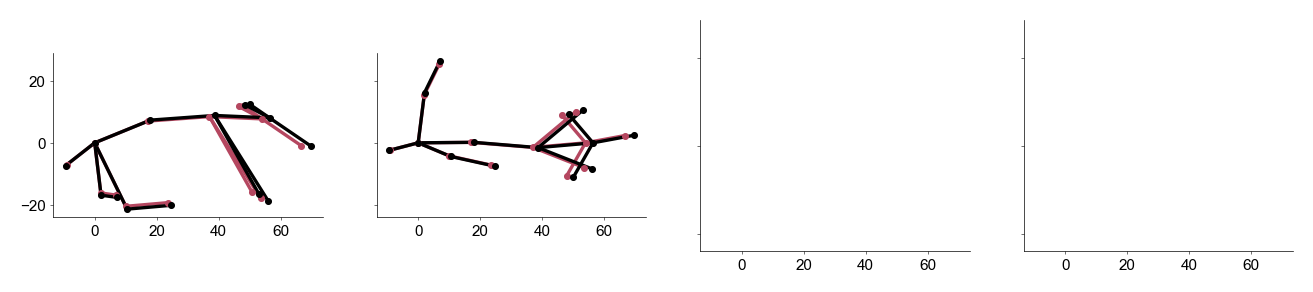

In [169]:
# scaled keypoints sanity check
fig, ax = plt.subplots(1, 4, figsize=(8, 1.5), sharex=True, sharey=True)
vu.plot_mouse_views(
    ax[[0, 1]],
    ntt_scaled_keypts['24wk_m0'][35],
    arms,
    color=age_pal['24'],
)
vu.plot_mouse_views(
    ax[[0, 1]],
    obs_keypts['24wk_m0'][35],
    arms,
    color='k',
)

### Keypoint frames

In [170]:
scores, scores_null = pairwise_group_acc(feat_scaled_kp_normed, age_groups, ref_age, tgt_ages)
indiv_across, indiv_null, indiv_within, indiv_self = pairwise_framewise_acc(feat_scaled_kp_normed, age_groups)
indiv = indiv_across, indiv_within, indiv_self, indiv_null

100%|██████████| 21/21 [00:16<00:00,  1.30it/s]


/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


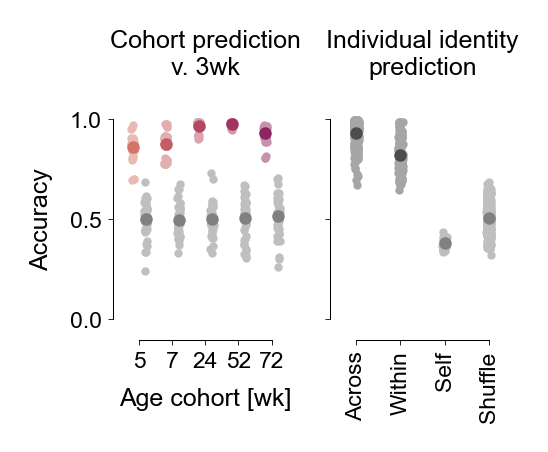

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.2_classif/raw_kp_pairwise.pdf')

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(1.8, 1.5), sharey=True, dpi = 150)

classif_strip(ax[0], tgt_ages, scores, [age_pal[a] for a in tgt_ages], -0.2)
classif_strip(ax[0], tgt_ages, scores_null, ['.5'] * len(tgt_ages), 0.2)
classif_strip(ax[1], range(4), indiv, ['.3', '.3', '.5', '.5'], 0)


ax[0].set_xticks(np.arange(len(tgt_ages)))
ax[0].set_xlim(-0.8, len(tgt_ages) - 1 + 0.8)
ax[1].set_xlim(-0.6, 3 + 0.6)
for a in ax:
    a.set_ylim(-0.1, 1.1)
    sns.despine(ax = a, trim = True)
    a.set_yticks([0.0, 0.5, 1.0])
ax[0].set_xticks(np.arange(len(tgt_ages)))
ax[0].set_xticklabels(tgt_ages)
ax[1].set_xticks(np.arange(4))
ax[1].set_xticklabels(["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Age cohort [wk]")
ax[0].set_title(f"Cohort prediction\nv. {ref_age}wk")
ax[1].set_title("Individual identity\nprediction")

plotter.finalize(fig, "raw_kp_pairwise", despine = False)

##### supp: keypoint frames, isolated to behaviors

In [128]:
scores_bhv = {}
for k in bhv_keys:
    feats = feats_within_bhv(k, feat_kp_normed)
    scores, scores_null = pairwise_group_acc(feats, age_groups, ref_age, tgt_ages)
    indiv_across, indiv_null, indiv_within, indiv_self = pairwise_framewise_acc(feats, age_groups)
    scores_bhv[k] = (scores, scores_null, (indiv_across, indiv_within, indiv_self, indiv_null))

100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of f

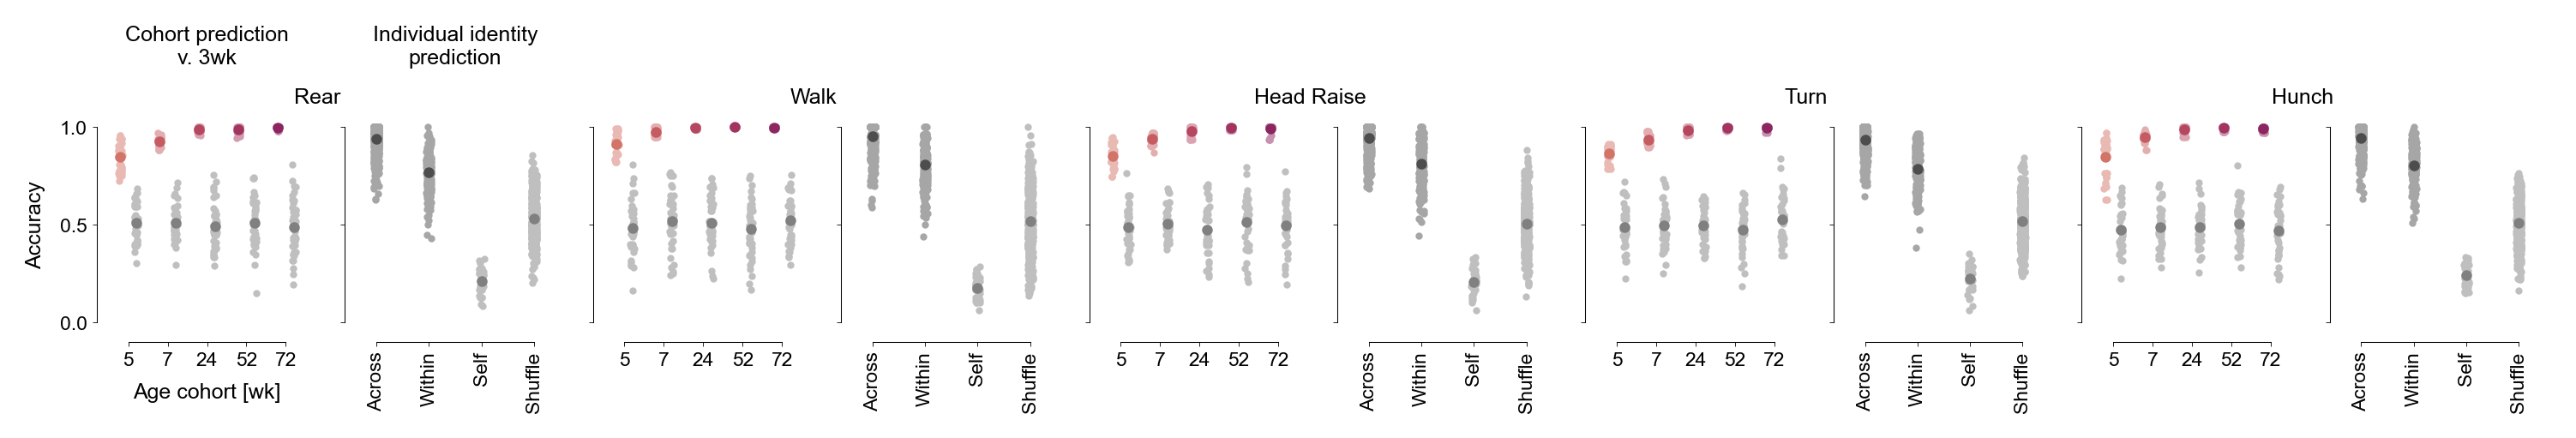

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.2_classif/raw_kp_pairwise_bhv.pdf')

In [142]:
nbhv = len(bhv_keys)
fig, ax = plt.subplots(1, 2 * nbhv, figsize=(10, 1.7), sharey=True, dpi = 150)

for i, k in enumerate(bhv_keys):
    classif_strip(ax[2*i], tgt_ages, scores_bhv[k][0], [age_pal[a] for a in tgt_ages], -0.2)
    classif_strip(ax[2*i], tgt_ages, scores_bhv[k][1], ['.5'] * len(tgt_ages), 0.2)
    classif_strip(ax[2*i + 1], range(4), scores_bhv[k][2], ['.3', '.3', '.5', '.5'], 0)

    ax[2*i].set_xticks(np.arange(len(tgt_ages)))
    ax[2*i].set_xticklabels(tgt_ages)
    ax[2*i].set_xlim(-0.8, len(tgt_ages) - 1 + 0.8)
    ax[2*i+1].set_xlim(-0.6, 3 + 0.6)
    ax[2*i+1].set_xticks(np.arange(4))
    ax[2*i+1].set_xticklabels(["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
    
for a in ax:
    a.set_ylim(-0.1, 1.1)
    sns.despine(ax = a, trim = True)
    a.set_yticks([0.0, 0.5, 1.0])


ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Age cohort [wk]")
ax[0].set_title(f"Cohort prediction\nv. {ref_age}wk\n")
ax[1].set_title("Individual identity\nprediction\n")

plt.tight_layout()
for i, k in enumerate(bhv_keys):
    ax[2*i].text(
        1, 1, bhv_names[k].replace('\n', ' '), ha = 'center', va = 'bottom', transform = ax[2*i].transAxes
    )

plotter.finalize(fig, "raw_kp_pairwise_bhv", despine = False, tight=False)

### Joint angles

In [173]:
scores_bhv = {}
for k in bhv_keys:
    feats = feats_within_bhv(k, feat_ja)
    scores, scores_null = pairwise_group_acc(feats, age_groups, ref_age, tgt_ages)
    indiv_across, indiv_null, indiv_within, indiv_self = pairwise_framewise_acc(feats, age_groups)
    scores_bhv[k] = (scores, scores_null, (indiv_across, indiv_within, indiv_self, indiv_null))

100%|██████████| 21/21 [00:07<00:00,  2.65it/s]


/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of f

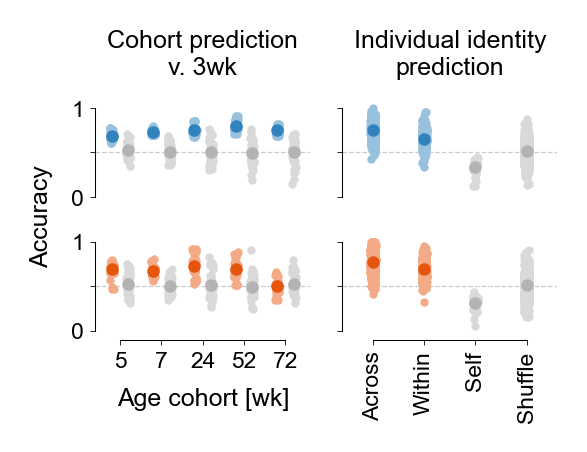

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.2_classif/ja-twobhv_pairwise.pdf')

In [220]:
fig, ax = plt.subplots(2, 2, figsize=(1.8, 1.5), sharey=True, dpi = 150)

classif_strip(ax[0, 0], tgt_ages, scores_bhv['rear'][1], ['.7'] * len(tgt_ages), 0.2)
classif_strip(ax[1, 0], tgt_ages, scores_bhv['loco'][1], ['.7'] * len(tgt_ages), 0.2)
classif_strip(ax[0, 0], tgt_ages, scores_bhv['rear'][0], [bhv_pal['rear']] * len(tgt_ages), -0.2)
classif_strip(ax[1, 0], tgt_ages, scores_bhv['loco'][0], [bhv_pal['loco']] * len(tgt_ages), -0.2)

classif_strip(ax[0, 1], range(4), scores_bhv['rear'][2], [bhv_pal['rear']] * 2 + ['.7', '.7'], 0)
classif_strip(ax[1, 1], range(4), scores_bhv['loco'][2], [bhv_pal['loco']] * 2 + ['.7', '.7'], 0)

for a in ax:
    a[0].set_xticks(np.arange(len(tgt_ages)))
    a[0].set_xlim(-0.6, len(tgt_ages) - 1 + 0.6)
    a[1].set_xlim(-0.6, 3 + 0.6)
    a[1].set_xticks(np.arange(4))


for a in ax.ravel():
    a.set_ylim(-0.1, 1.1)
    a.set_yticks([0.0, 0.5, 1.0])
    a.set_yticklabels(["0", "", "1"])
    a.axhline(0.5, color = '.8', ls = '--', lw = 0.3, zorder = -2)
for a in ax[0]:
    a.set_xticks([])
    sns.despine(ax = a, trim = True, bottom=True)
for a in ax[1]:
    sns.despine(ax = a, trim = True)


ax[1, 0].set_xticklabels(tgt_ages)
ax[1, 1].set_xticklabels(["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
ax[1, 0].set_xlabel("Age cohort [wk]")
ax[0, 0].set_title(f"Cohort prediction\nv. {ref_age}wk")
ax[0, 1].set_title("Individual identity\nprediction")
fig.text(-0.25, -0.1, "Accuracy", ha = 'center', va = 'center', transform = ax[0, 0].transAxes, rotation = 90)

plotter.finalize(fig, "ja-twobhv_pairwise", despine = False)

/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of f

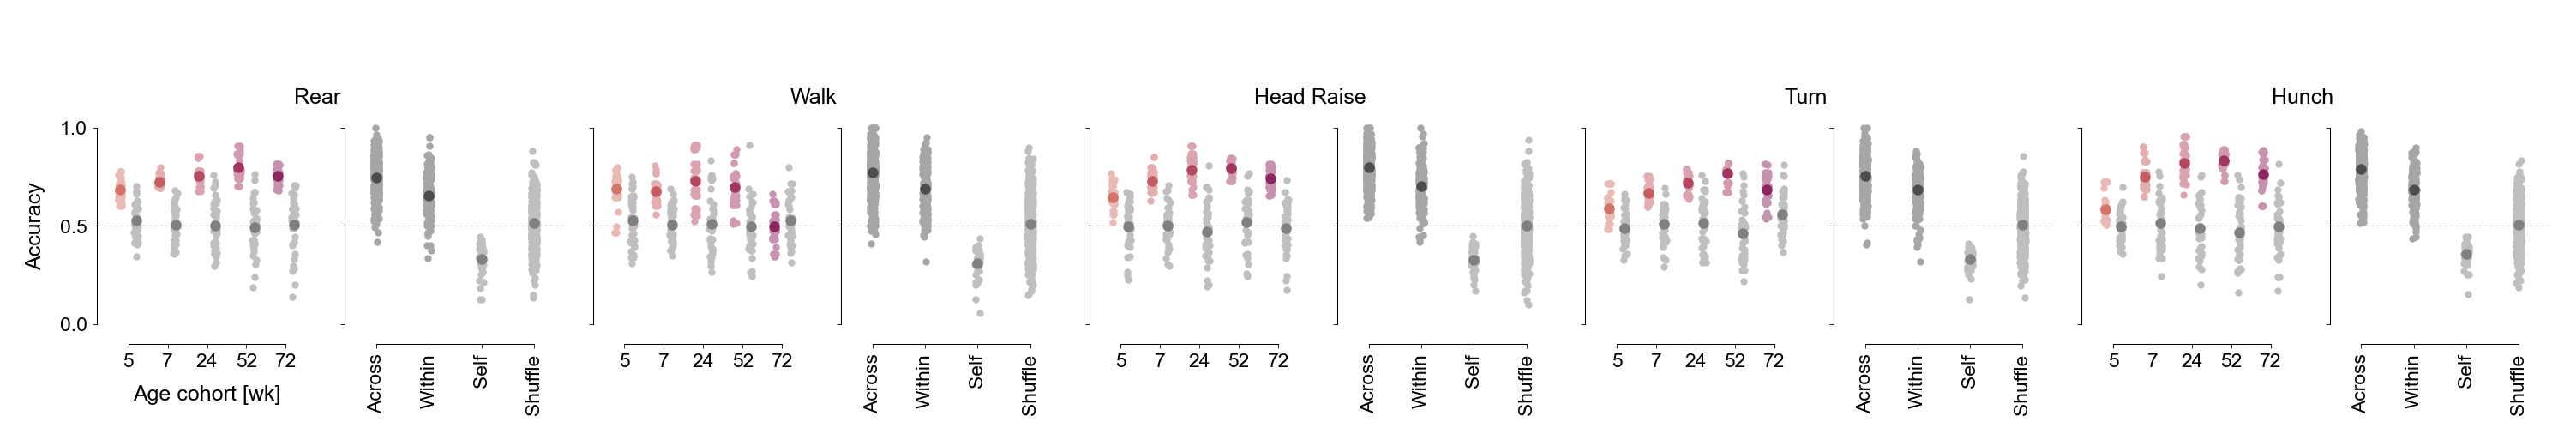

PosixPath('/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.2_classif/ja_pairwise_bhv.pdf')

In [215]:
nbhv = len(bhv_keys)
fig, ax = plt.subplots(1, 2 * nbhv, figsize=(10, 1.7), sharey=True, dpi = 150)

for i, k in enumerate(bhv_keys):
    classif_strip(ax[2*i], tgt_ages, scores_bhv[k][0], [age_pal[a] for a in tgt_ages], -0.2)
    classif_strip(ax[2*i], tgt_ages, scores_bhv[k][1], ['.5'] * len(tgt_ages), 0.2)
    classif_strip(ax[2*i + 1], range(4), scores_bhv[k][2], ['.3', '.3', '.5', '.5'], 0)

    ax[2*i].set_xticks(np.arange(len(tgt_ages)))
    ax[2*i].set_xticklabels(tgt_ages)
    ax[2*i].set_xlim(-0.8, len(tgt_ages) - 1 + 0.8)
    ax[2*i+1].set_xlim(-0.6, 3 + 0.6)
    ax[2*i+1].set_xticks(np.arange(4))
    ax[2*i+1].set_xticklabels(["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
    
for a in ax:
    a.set_ylim(-0.1, 1.1)
    sns.despine(ax = a, trim = True)
    a.set_yticks([0.0, 0.5, 1.0])
    a.axhline(0.5, color = '.8', ls = '--', lw = 0.3, zorder = -2)


ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Age cohort [wk]")
ax[0].set_title(f"\n\n")
ax[1].set_title("\n\n")

plt.tight_layout()
for i, k in enumerate(bhv_keys):
    ax[2*i].text(
        1, 1, bhv_names[k].replace('\n', ' '), ha = 'center', va = 'bottom', transform = ax[2*i].transAxes
    )

plotter.finalize(fig, "ja_pairwise_bhv", despine = False, tight=False)